<a href="https://colab.research.google.com/github/AAEO04/final-year-project/blob/main/final_year_project_lowcarbonsteelweld0.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


!pip install tensorflow opencv-python-headless pandas tqdm scikit-learn matplotlib seaborn

!pip install tensorflow opencv-python-headless pandas tqdm scikit-learn matplotlib seaborn

!pip install tensorflow opencv-python-headless pandas tqdm scikit-learn matplotlib seaborn

!pip install tensorflow opencv-python-headless pandas tqdm scikit-learn matplotlib seaborn

!pip install tensorflow opencv-python-headless pandas tqdm scikit-learn matplotlib seaborn

!pip install tensorflow opencv-python-headless pandas tqdm scikit-learn matplotlib seaborn

In [2]:
!pip install tensorflow opencv-python-headless pandas tqdm scikit-learn matplotlib seaborn

In [3]:
import os
import shutil
import requests
import zipfile
import pandas as pd
import cv2
import numpy as np
import tensorflow as tf
from pathlib import Path
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.utils import compute_class_weight
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve, confusion_matrix
from tensorflow.keras.applications import ResNet50, MobileNetV3Small
from tensorflow.keras.applications.resnet50 import preprocess_input as resnet_preprocess_input # Specific import for ResNet
# from tensorflow.keras.applications.mobilenet_v3 import preprocess_input as mobilenet_preprocess_input # If using MobileNetV3
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from google.colab import files

# Set random seeds for reproducibility
SEED = 42
np.random.seed(SEED)
tf.random.set_seed(SEED)

In [4]:
!git clone https://github.com/stefyste/RIAWELC.git
from pathlib import Path # Import the Path object from pathlib
DATASET_BASE_DIR = Path("RIAWELC")

Cloning into 'RIAWELC'...
remote: Enumerating objects: 528, done.
remote: Counting objects: 100% (146/146), done.
remote: Compressing objects: 100% (146/146), done.
remote: Total 528 (delta 4), reused 103 (delta 0), pack-reused 382 (from 1)
Receiving objects: 100% (528/528), 471.32 MiB | 23.78 MiB/s, done.
Resolving deltas: 100% (23/23), done.
Updating files: 100% (20/20), done.


In [5]:
import os
import subprocess
from pathlib import Path

# --- Configuration ---
# IMPORTANT: Adjust these paths!
# Path to the directory containing your .part*.rar files
source_rar_dir = Path("/content/RIAWELC/Dataset_partitioned")
# Path where you want the extracted data to be placed
output_extracted_dir = Path("/content/RIAWELC/RIAWELC_extracted_unrar")
# The name of the first part of the RAR archive
first_rar_filename = "RIAWELC_dataset.part01.rar"
# Full path to the first RAR file
first_rar_file = source_rar_dir / first_rar_filename

# --- Installation (uncomment if needed) ---
# Run this cell once if unrar is not available
# !apt-get update
# !apt-get install unrar -y

# --- Create Output Directory ---
# Ensure the output directory exists
os.makedirs(output_extracted_dir, exist_ok=True)
print(f"Ensuring output directory exists: {output_extracted_dir}")

# --- Extraction using unrar ---
print(f"\nStarting extraction of {first_rar_file} to {output_extracted_dir} using unrar...")

try:
    # The 'x' flag extracts with full paths
    # The command is run from the current directory, so we use the full path to the rar file
    # We specify the output directory as the last argument
    result = subprocess.run(
        ['unrar', 'x', str(first_rar_file), str(output_extracted_dir)],
        check=True, # Raise CalledProcessError if command returns non-zero exit code
        capture_output=True, # Capture stdout and stderr
        text=True # Decode output as text
    )
    print("unrar stdout:\n", result.stdout)
    print("unrar stderr:\n", result.stderr)
    print("\nExtraction command finished.")

except FileNotFoundError:
    print("Error: 'unrar' command not found. Please run the installation cell.")
except subprocess.CalledProcessError as e:
    print(f"Error during unrar extraction: {e}")
    print("Stderr:", e.stderr)
    print("Stdout:", e.stdout)
except Exception as e:
    print(f"An unexpected error occurred during extraction: {e}")


# --- Verification Check ---
print("\nVerifying extraction...")

if output_extracted_dir.exists():
    print(f"Output directory exists: {output_extracted_dir}")

    # Check if the directory is not empty
    if any(output_extracted_dir.iterdir()):
        print("Output directory is NOT empty. Extraction likely successful.")
        # You can list contents to verify
        # print("\nContents of extracted directory:")
        # !ls -R "{output_extracted_dir}" # Use !ls for shell command output

        # --- Optional: More specific check ---
        # If you know a specific file or folder that should exist after extraction,
        # you can check for its presence. For example, checking for the 'training' folder:
        expected_subdir = output_extracted_dir / "RIAWELC" # Adjust based on actual extracted structure
        if expected_subdir.exists():
             print(f"Expected subdirectory found: {expected_subdir}")
             # You might check for training/testing inside this
             # if (expected_subdir / "training").exists() and (expected_subdir / "testing").exists():
             #     print("Training and testing subdirectories found.")
        else:
             print(f"Warning: Expected subdirectory '{expected_subdir}' not found.")


    else:
        print("Output directory is EMPTY. Extraction may have failed or archive was empty.")
else:
    print("Output directory does NOT exist. Extraction failed.")

print("\nVerification complete.")


Streaming output truncated to the last 5000 lines.
Extracting  /content/RIAWELC/RIAWELC_extracted_unrar/DB - Copy/validation/Difetto1/RRT-88R_Img2_A80_S4_[23][24].png      79%  OK 
Extracting  /content/RIAWELC/RIAWELC_extracted_unrar/DB - Copy/validation/Difetto1/RRT-88R_Img2_A80_S4_[23][28].png      79%  OK 
Extracting  /content/RIAWELC/RIAWELC_extracted_unrar/DB - Copy/validation/Difetto1/RRT-88R_Img2_A80_S4_[24][17].png      79%  OK 
Extracting  /content/RIAWELC/RIAWELC_extracted_unrar/DB - Copy/validation/Difetto1/RRT-88R_Img2_A80_S4_[26][34].png      79%  OK 
Extracting  /content/RIAWELC/RIAWELC_extracted_unrar/DB - Copy/validation/Difetto1/RRT-88R_Img2_A80_S4_[28][33].png      79%  OK 
Extracting  /content/RIAWELC/RIAWELC_extracted_unrar/DB - Copy/validation/Difetto1/RRT-88R_Img2_A80_S4_[28][35].png      79%  OK 
Extracting  /content/RIAWELC/RIAWELC_extracted_unrar/DB - Copy/validation/Difetto1/RRT-88R_Img2_A80_S4_[28][38].png

In [6]:
import os
import shutil
from pathlib import Path

# Define the paths
base_dir = Path("/content/RIAWELC/RIAWELC_extracted_unrar/DB - Copy")  # Path to your dataset
data_splits = ["training", "testing", "validation"]  # Data splits to process

# Define the folder mapping
folder_mapping = {
    "Difetto1": "LP",
    "Difetto2": "PO",
    "Difetto4": "CR",
    "NoDifetto": "ND",
}

# Loop through data splits and rename folders
for split in data_splits:
    split_dir = base_dir / split
    for old_name, new_name in folder_mapping.items():
        old_folder = split_dir / old_name
        new_folder = split_dir / new_name
        if old_folder.exists():
            shutil.move(str(old_folder), str(new_folder))
            print(f"Renamed '{old_folder}' to '{new_folder}'")
        else:
            print(f"Folder '{old_folder}' not found.")

print("Folder renaming complete.")

Renamed '/content/RIAWELC/RIAWELC_extracted_unrar/DB - Copy/training/Difetto1' to '/content/RIAWELC/RIAWELC_extracted_unrar/DB - Copy/training/LP'
Renamed '/content/RIAWELC/RIAWELC_extracted_unrar/DB - Copy/training/Difetto2' to '/content/RIAWELC/RIAWELC_extracted_unrar/DB - Copy/training/PO'
Renamed '/content/RIAWELC/RIAWELC_extracted_unrar/DB - Copy/training/Difetto4' to '/content/RIAWELC/RIAWELC_extracted_unrar/DB - Copy/training/CR'
Renamed '/content/RIAWELC/RIAWELC_extracted_unrar/DB - Copy/training/NoDifetto' to '/content/RIAWELC/RIAWELC_extracted_unrar/DB - Copy/training/ND'
Renamed '/content/RIAWELC/RIAWELC_extracted_unrar/DB - Copy/testing/Difetto1' to '/content/RIAWELC/RIAWELC_extracted_unrar/DB - Copy/testing/LP'
Renamed '/content/RIAWELC/RIAWELC_extracted_unrar/DB - Copy/testing/Difetto2' to '/content/RIAWELC/RIAWELC_extracted_unrar/DB - Copy/testing/PO'
Renamed '/content/RIAWELC/RIAWELC_extracted_unrar/DB - Copy/testing/Difetto4' to '/content/RIAWELC/RIAWELC_extracted_unra

In [7]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.metrics import classification_report

print("All libraries imported successfully.")

All libraries imported successfully.


In [8]:
BASE_DATA_DIR = "/content/RIAWELC/RIAWELC_extracted_unrar/DB - Copy/"
TRAIN_DIR = os.path.join(BASE_DATA_DIR, "training")
VALIDATION_DIR = os.path.join(BASE_DATA_DIR, "validation")
TEST_DIR = os.path.join(BASE_DATA_DIR, "testing")

IMG_WIDTH, IMG_HEIGHT = 224, 224
IMG_SIZE = (IMG_WIDTH, IMG_HEIGHT)
BATCH_SIZE = 32
CLASS_NAMES = ['LP', 'PO', 'CR', 'ND']

if all(os.path.exists(dir) for dir in [TRAIN_DIR, VALIDATION_DIR, TEST_DIR]):
    print("All dataset directories exist.")
else:
    print("Warning: One or more dataset directories are missing.")

All dataset directories exist.


In [9]:

train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=15,
    horizontal_flip=True,
    shear_range=0.2,
    zoom_range=0.2
)

val_test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    TRAIN_DIR,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    classes=CLASS_NAMES,
    shuffle=True
)

val_generator = val_test_datagen.flow_from_directory(
    VALIDATION_DIR,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    classes=CLASS_NAMES,
    shuffle=False
)

test_generator = val_test_datagen.flow_from_directory(
    TEST_DIR,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    classes=CLASS_NAMES,
    shuffle=False
)

Found 15863 images belonging to 4 classes.
Found 6101 images belonging to 4 classes.
Found 2443 images belonging to 4 classes.


In [10]:
# --- Model Definition ---
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(IMG_WIDTH, IMG_HEIGHT, 3))

for layer in base_model.layers:
    layer.trainable = False

num_layers_to_unfreeze = 30
for layer in base_model.layers[-num_layers_to_unfreeze:]:
    layer.trainable = True

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
predictions = Dense(len(CLASS_NAMES), activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=predictions)

model.summary()

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 230, 230,  │          0 │ input_layer[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 112, 112,  │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 112, 112,  │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 112, 112,  │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 114, 114,  │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 56, 56,    │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 56, 56,    │      4,160 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 56, 56,    │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 56, 56,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 56, 56,    │     36,928 │ conv2_block1_1_r… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 56, 56,    │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 56, 56,    │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 56, 56,    │     16,640 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 56, 56,    │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_0_c… │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_3_c

 Total params: 25,689,988 (98.00 MB)

 Trainable params: 16,552,452 (63.14 MB)

 Non-trainable params: 9,137,536 (34.86 MB)

In [11]:
# --- Model Compilation ---
model.compile(
    optimizer=Adam(learning_rate=1e-4),
    loss='categorical_crossentropy',
    metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall(), tf.keras.metrics.F1Score()]
)

print("Model compiled successfully.")




Model compiled successfully.


In [12]:
 #--- Callbacks ---
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
model_checkpoint = ModelCheckpoint('best_model.h5', monitor='val_loss', save_best_only=True)

print("Callbacks defined successfully.")

Callbacks defined successfully.


In [13]:
# --- Model Training ---
history = model.fit(
    train_generator,
    epochs=50,
    validation_data=val_generator,
    callbacks=[early_stopping, model_checkpoint]
)

print("Training completed.")

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/50
496/496 ━━━━━━━━━━━━━━━━━━━━ 0s 426ms/step - accuracy: 0.4392 - f1_score: 0.4255 - loss: 1.2202 - precision: 0.5441 - recall: 0.2175

496/496 ━━━━━━━━━━━━━━━━━━━━ 279s 516ms/step - accuracy: 0.4393 - f1_score: 0.4256 - loss: 1.2201 - precision: 0.5442 - recall: 0.2176 - val_accuracy: 0.3468 - val_f1_score: 0.2021 - val_loss: 6.2899 - val_precision: 0.3462 - val_recall: 0.3444
Epoch 2/50
496/496 ━━━━━━━━━━━━━━━━━━━━ 0s 410ms/step - accuracy: 0.5443 - f1_score: 0.5349 - loss: 1.0382 - precision: 0.6555 - recall: 0.3562

496/496 ━━━━━━━━━━━━━━━━━━━━ 276s 446ms/step - accuracy: 0.5443 - f1_score: 0.5349 - loss: 1.0381 - precision: 0.6555 - recall: 0.3563 - val_accuracy: 0.3057 - val_f1_score: 0.2105 - val_loss: 4.5961 - val_precision: 0.3052 - val_recall: 0.3008
Epoch 3/50
496/496 ━━━━━━━━━━━━━━━━━━━━ 221s 446ms/step - accuracy: 0.5970 - f1_score: 0.5857 - loss: 0.9476 - precision: 0.6978 - recall: 0.4465 - val_accuracy: 0.3081 - val_f1_score: 0.2143 - val_loss: 4.8734 - val_precision: 0.3088 - val_recall: 0.3031
Epoch 4/50
496/496 ━━━━━━━━━━━━━━━━━━━━ 220s 443ms/step - accuracy: 0.6433 - f1_score: 0.6366 - loss: 0.8664 - precision: 0.7298 - recall: 0.5279 - val_accuracy: 0.3573 - val_f1_score: 0.2397 - val_loss: 6.5850 - val_precision: 0.3576 - val_recall: 0.3573
Epoch 5/50
496/496 ━━━━━━━━━━━━━━━━━━━━ 219s 441ms/step - accuracy: 0.6636 - f1_score: 0.6552 - loss: 0.8184 - precision: 0.7371 - recall: 0.5542 - val_accuracy: 0.3231 - val_f1_score: 0.2423 - val_loss: 4.9821 - val_precision: 0.3195 - val_re

In [14]:
# --- Model Evaluation ---
test_loss, test_acc, test_precision, test_recall, test_f1 = model.evaluate(test_generator)
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_acc:.4f}")
print(f"Test Precision: {test_precision:.4f}")
print(f"Test Recall: {test_recall:.4f}")
print(f"Test F1 Score: {test_f1:.4f}")

# Per-class metrics
y_pred = model.predict(test_generator)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = test_generator.classes
print("\nClassification Report:")
print(classification_report(y_true, y_pred_classes, target_names=CLASS_NAMES))

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred_classes)
print("\nConfusion Matrix:")
print(cm)

# Per-Class Accuracy
print("\nPer-Class Accuracy:")
for i, class_name in enumerate(CLASS_NAMES):
    class_acc = cm[i, i] / cm[i].sum() if cm[i].sum() > 0 else 0
    print(f"{class_name}: {class_acc:.4f}")

# ROC-AUC
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import label_binarize
y_true_bin = label_binarize(y_true, classes=range(len(CLASS_NAMES)))
roc_auc = roc_auc_score(y_true_bin, y_pred, multi_class='ovr')
print(f"\nROC-AUC (One-vs-Rest, Macro-Averaged): {roc_auc:.4f}")

# Precision-Recall Curve and Average Precision
from sklearn.metrics import precision_recall_curve, average_precision_score
plt.figure(figsize=(10, 8))
for i, class_name in enumerate(CLASS_NAMES):
    precision, recall, _ = precision_recall_curve(y_true_bin[:, i], y_pred[:, i])
    ap = average_precision_score(y_true_bin[:, i], y_pred[:, i])
    plt.plot(recall, precision, label=f'{class_name} (AP = {ap:.2f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curves')
plt.legend()
plt.grid(True)
plt.show()

# Cohen’s Kappa
from sklearn.metrics import cohen_kappa_score
kappa = cohen_kappa_score(y_true, y_pred_classes)
print(f"\nCohen’s Kappa: {kappa:.4f}")

# Visualize Confusion Matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=CLASS_NAMES, yticklabels=CLASS_NAMES)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

print("Model evaluation and additional metrics completed.")

77/77 ━━━━━━━━━━━━━━━━━━━━ 10s 134ms/step - accuracy: 0.2716 - f1_score: 0.1463 - loss: 2.0648 - precision: 0.2719 - recall: 0.2688
Test Loss: 4.6330
Test Accuracy: 0.3013
Test Precision: 0.3010
Test Recall: 0.2976


TypeError: unsupported format string passed to numpy.ndarray.__format__

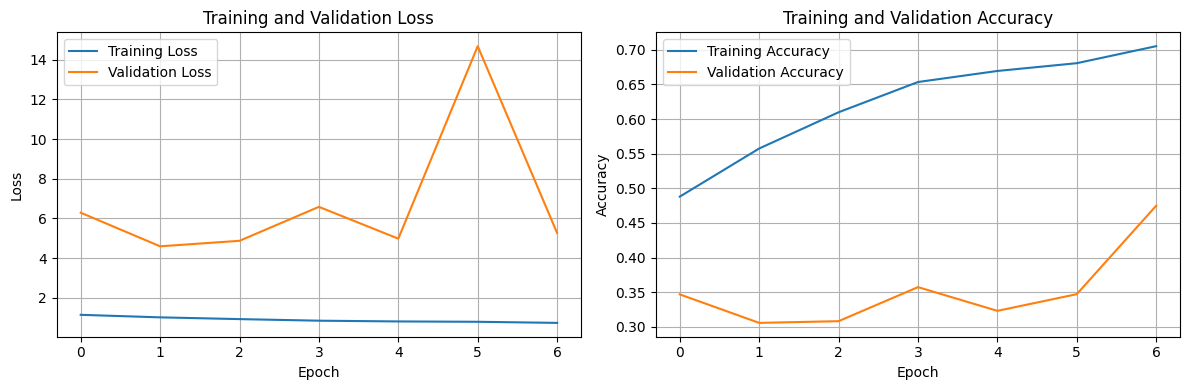

Training history plots generated.


In [15]:
# --- Training History Plots ---
plt.figure(figsize=(12, 4))

# Loss Plot
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

# Accuracy Plot
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

print("Training history plots generated.")